# Transfer Learning on Dataverse dataset using VGG16

We first attempt to perform classification on the Dataverse dataset by leveraging transfer learning using the VGG16 model pretrained on imagenet. We freeze all the layers except the top and train on the dataset using class weights to prevent class imbalance.

Dataverse dataset consists of 4 classes: Macular Degeneration, Macular Hole, Diabetic Retinopathy and Normal

Training was done with augmentations using ImageDataGenerator and 80-20% dataset split for train and test sets.
We did training for 30 epochs and batch size of 128, with early stopping on val_accuracy.

Our observations are that model fits to the data well, giving ~91% test set accuracy. This may be due to low amount of data in dataset.
We display classification report, accuracy and loss graphs, ros curves for each class and confusion matrix.


In [1]:
path = "/kaggle/input/ai-in-healthcare-hackathon/DataVerse_Dataset"

In [2]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import random
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
dirr = os.listdir(path)

## Processing to split in train-test set(80:20)

In [4]:
def labeller(j):
    if j.startswith("AMRD"): return 'Macular Degeneration'
    elif j.startswith("MH"): return 'Macular Hole'
    elif j.startswith("DR"): return 'Diabetic Retinopathy'
    else: return 'Normal'

In [5]:
test_path = []
train_path = []
test_label = []
train_label = []
for i in range(4):
    dir_name = dirr[i]
    full_path = os.path.join(path,dir_name)
    image_dir = os.listdir(full_path)
    test_len = int(0.2*len(image_dir))
    test_dir = random.sample(image_dir, test_len)
    for j in test_dir:
        test_path.append(os.path.join(path,dir_name,j))
        test_label.append(labeller(j))
        
    for j in image_dir:
        if j in test_dir:
            continue
        train_path.append(os.path.join(path,dir_name,j))
        train_label.append(labeller(j))

In [6]:
df_train = pd.DataFrame(list(zip(train_path, train_label)),
               columns =['image_path', 'label'])

df_test = pd.DataFrame(list(zip(test_path, test_label)),
               columns =['image_path', 'label'])

<AxesSubplot:xlabel='label', ylabel='count'>

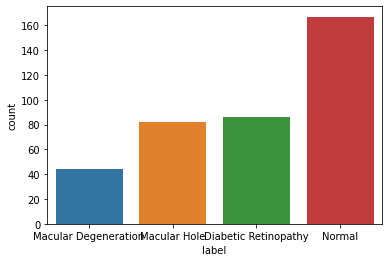

In [7]:
# Train distribution
import seaborn as sns
df = df_train
lab = df['label']
dist = lab.value_counts()
sns.countplot(x = lab)

<AxesSubplot:xlabel='label', ylabel='count'>

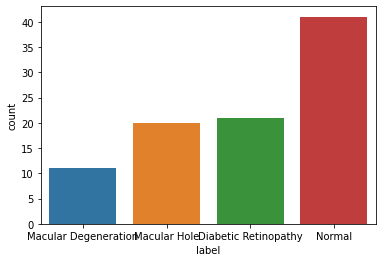

In [8]:
#Test Distribution
df = df_test
lab = df['label']
dist = lab.value_counts()
sns.countplot(x = lab)

## Data generator, augmentation

In [9]:
train_aug = ImageDataGenerator(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    rescale = 1./255)

test_aug = ImageDataGenerator(
    rescale = 1./255)

train_generator= train_aug.flow_from_dataframe(
dataframe=df_train,
x_col="image_path",
y_col="label",
batch_size=128,
seed=42,
color_mode="rgb",
target_size = (224, 224),
shuffle=True,
class_mode="categorical")

test_generator= test_aug.flow_from_dataframe(
dataframe=df_test,
x_col="image_path",
y_col="label",
color_mode="rgb",
batch_size=128,
target_size = (224, 224),
seed=42,
shuffle=False,
class_mode="categorical")

Found 377 validated image filenames belonging to 4 classes.
Found 93 validated image filenames belonging to 4 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


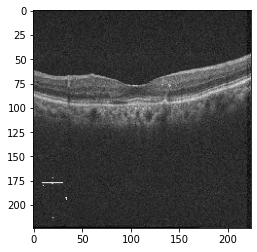

In [10]:
plt.imshow(test_generator[0][0][2])

## Model building

In [11]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
def generate_model(pretrained_model = 'vgg16', num_classes = 4):
    if pretrained_model == 'inceptionv3':
        weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
        base_model = InceptionV3(weights = weight_path, include_top=False, input_shape=(224, 224, 3))
    else:
        weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        base_model = VGG16(weights = weight_path, include_top=False, input_shape=(224, 224, 3)) # Topless
    
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
        
    return model

model = generate_model('vgg16', 4)

In [12]:
# Adding class weights to adjust imbalance
from sklearn.utils import class_weight
map_characters = test_generator.class_indices
print(map_characters)
class_weights = dict(zip(map_characters.values(), class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_label), 
                y=train_label))) 
print("Class Weights: ",class_weights)

{'Diabetic Retinopathy': 0, 'Macular Degeneration': 1, 'Macular Hole': 2, 'Normal': 3}
Class Weights:  {0: 1.1017441860465116, 1: 2.153409090909091, 2: 1.1554878048780488, 3: 0.5673652694610778}


# Training

In [13]:
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
    factor=0.1,
    patience=4)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=7, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=test_generator, class_weight = class_weights, epochs = 30, callbacks = [rlr, early_stop])

Epoch 1/30
3/3 [==============================] - 37s 10s/step - loss: 2.1265 - accuracy: 0.2332 - val_loss: 1.1250 - val_accuracy: 0.4946
Epoch 2/30
3/3 [==============================] - 8s 3s/step - loss: 1.3532 - accuracy: 0.3793 - val_loss: 1.1039 - val_accuracy: 0.5484
Epoch 3/30
3/3 [==============================] - 7s 2s/step - loss: 0.8952 - accuracy: 0.5718 - val_loss: 0.7075 - val_accuracy: 0.6774
Epoch 4/30
3/3 [==============================] - 8s 3s/step - loss: 0.8486 - accuracy: 0.7428 - val_loss: 0.5137 - val_accuracy: 0.8495
Epoch 5/30
3/3 [==============================] - 7s 3s/step - loss: 0.5842 - accuracy: 0.8077 - val_loss: 0.5989 - val_accuracy: 0.8065
Epoch 6/30
3/3 [==============================] - 7s 3s/step - loss: 0.4501 - accuracy: 0.8635 - val_loss: 0.4022 - val_accuracy: 0.8925
Epoch 7/30
3/3 [==============================] - 7s 3s/step - loss: 0.3847 - accuracy: 0.9269 - val_loss: 0.3422 - val_accuracy: 0.9032
Epoch 8/30
3/3 [=======================

Plot model accuracy

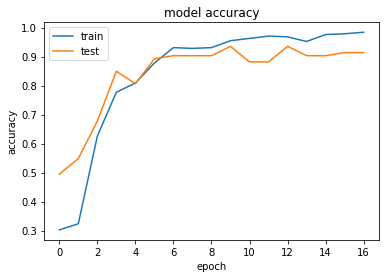

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Plot model loss

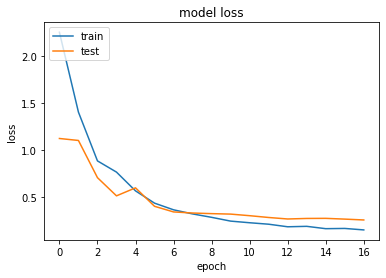

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Classification report (recall, precision, f1 score)

In [16]:
from sklearn import metrics
y_true = np.array(test_generator.labels)
y_pred = model.predict(test_generator, verbose = 1)
y_pred_classes = np.argmax(y_pred,axis = 1)
class_labels = list(test_generator.class_indices.keys())   

1/1 [==============================] - 1s 1000ms/step


In [17]:
print('\n', metrics.classification_report(y_true, y_pred_classes, target_names=class_labels), sep='')


                      precision    recall  f1-score   support

Diabetic Retinopathy       0.85      0.81      0.83        21
Macular Degeneration       0.91      0.91      0.91        11
        Macular Hole       0.85      0.85      0.85        20
              Normal       0.98      1.00      0.99        41

            accuracy                           0.91        93
           macro avg       0.90      0.89      0.89        93
        weighted avg       0.91      0.91      0.91        93



ROC curves

In [18]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_true)
y_test = lb.transform(y_true)

In [19]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

ROS AUC score: 0.9801217957958687


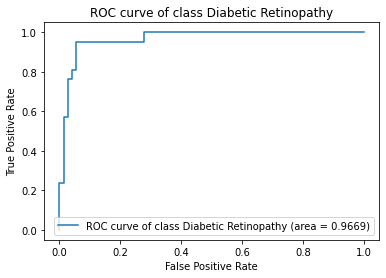

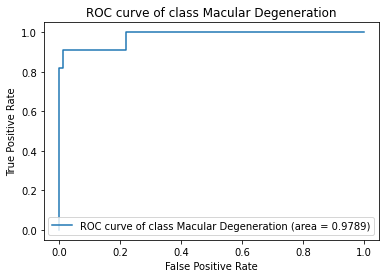

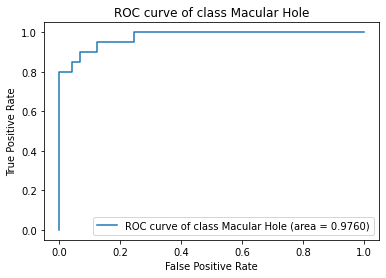

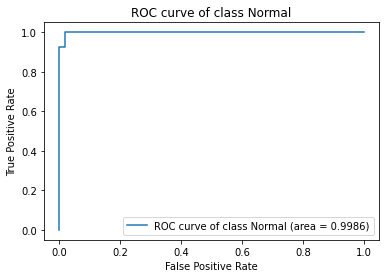

In [20]:
print("ROS AUC score:", roc_auc_score(y_test, y_pred))
# Plot all ROC curves
for i in range(4):
    fig, c_ax = plt.subplots(1,1, figsize = (6, 4))
    c_ax.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(class_labels[i], roc_auc[i]))
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    c_ax.set_title('ROC curve of class {0}'.format(class_labels[i]))
    c_ax.legend(loc="lower right")
    plt.show() 

Plot confusion matrix

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

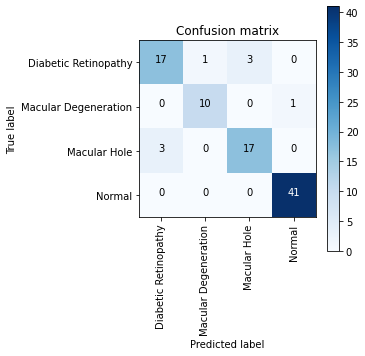

In [22]:
from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.keys()))
plt.show()